# Barcelona

Detection of Spatial Signatures in FUA of Barcelona.

1. [ ] data retrieval
    - [x] footprints (cadastre)
    - [x] street network (open data portal https://opendata-ajuntament.barcelona.cat/data/en/)
    - [ ] functional layers (open data portal)
    - [x] barriers (OSM)
2. [x] data pre-processing
    - [x] footprints checks
    - [x] barries checks
3. [x] generate geographies
    - [x] enclosures
    - [x] enclosed tessellation
4. [ ] morphometrics
    - [ ] primary characters
    - [ ] convolutions
5. [ ] functional layers
6. [ ] cluster analysis

In [1]:
import requests
import geopandas as gpd
from download import download
import osmnx as ox
import momepy
import libpysal
import numpy as np
import warnings

import utils.momepy

In [2]:
warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')

In [14]:
data = "https://opendata-ajuntament.barcelona.cat/data/dataset/6fd03b36-7503-42f0-9082-9040cb812423/resource/a11a534d-4aeb-497f-b6bd-2e170b4724aa/download"
path = "../../urbangrammar_samba/sp_sig_concept/barcelona/streets"
download(data, path, kind='zip')

Creating data folder...

file_sizes: 100%|██████████████████████████| 1.84M/1.84M [00:01<00:00, 1.23MB/s]
Extracting zip file...
Successfully downloaded / unzipped to ../../urbangrammar_samba/sp_sig_concept/barcelona/streets


'../../urbangrammar_samba/sp_sig_concept/barcelona/streets'

In [16]:
response = requests.get('http://www.catastro.minhap.es/INSPIRE/buildings/08/ES.SDGC.bu.atom_08.xml')
links = []

for link in response.text.split('<link rel="enclosure" href="')[1:]:
    links.append(link.split('"')[0].strip())

In [18]:
bcn = [l for l in links if 'BARCELONA' in l]

In [19]:
bcn

['http://www.catastro.minhap.es/INSPIRE/Buildings/08/08900-BARCELONA/A.ES.SDGC.BU.08900.zip']

In [20]:
data = bcn[0]
path = "../../urbangrammar_samba/sp_sig_concept/barcelona/buildings"
download(data, path, kind='zip')

Creating data folder...

file_sizes: 100%|██████████████████████████| 44.4M/44.4M [00:11<00:00, 3.70MB/s]
Extracting zip file...
Successfully downloaded / unzipped to ../../urbangrammar_samba/sp_sig_concept/barcelona/buildings


'../../urbangrammar_samba/sp_sig_concept/barcelona/buildings'

In [22]:
buildings = gpd.read_file("../../urbangrammar_samba/sp_sig_concept/barcelona/buildings/A.ES.SDGC.BU.08900.building.gml")

In [23]:
roads = gpd.read_file("../../urbangrammar_samba/sp_sig_concept/barcelona/streets/BCN_GrafVial_Trams_ETRS89_SHP.shp")

<AxesSubplot:>

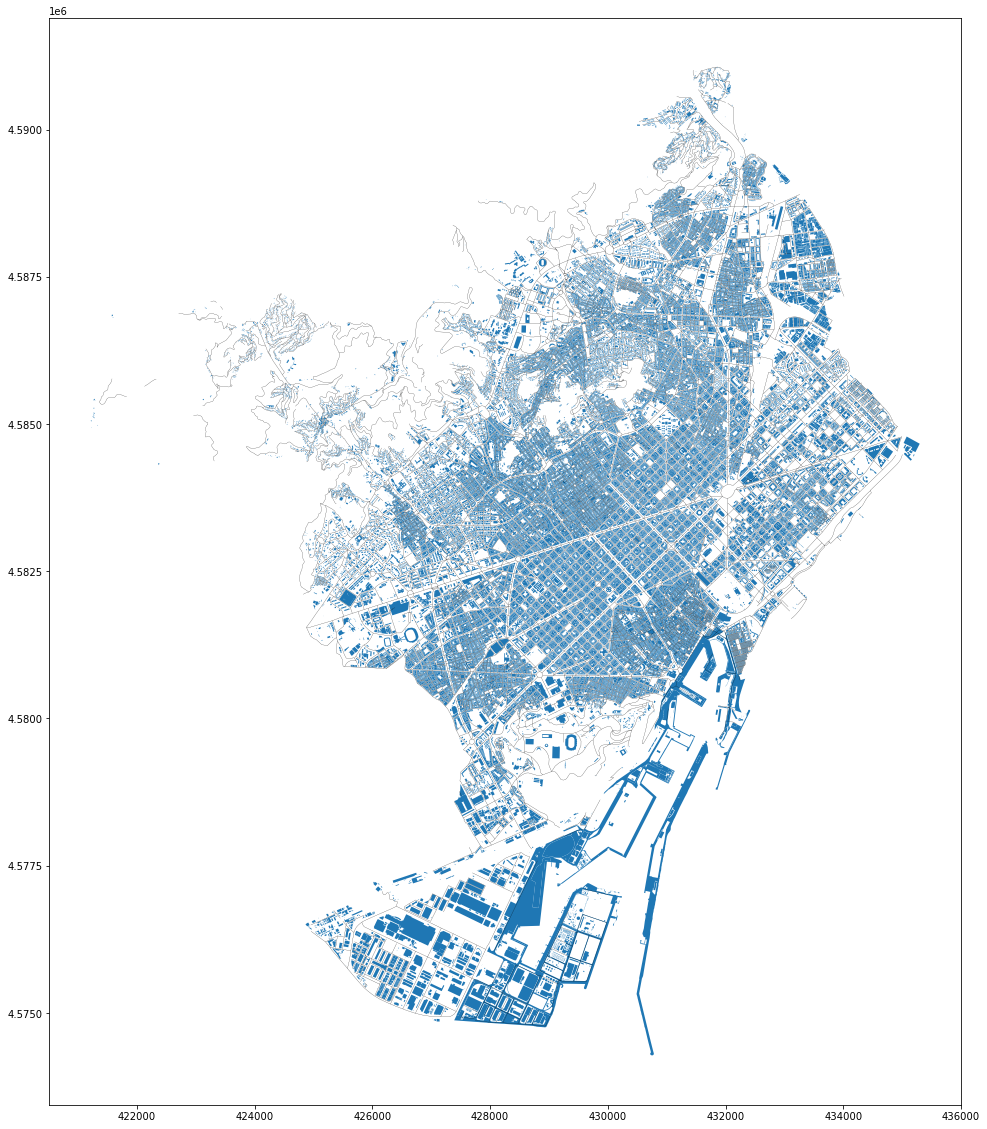

In [24]:
ax = buildings.plot(figsize=(20, 20))
roads.plot(ax=ax, linewidth=.2, color='k')

## OSM barriers

Identification of enclosures should optimally contain variety of barriers, not only street networks. Therefore we download railway and water geometry from OSM. 

The required version of `OSMnx` for this section is 0.16+ which includes `geometries` module.

In [50]:
bounds = roads.to_crs(4326).total_bounds
bounds

array([ 2.05905748, 41.32133238,  2.22232372, 41.46827616])

In [55]:
tags = {'natural': ['water', 'coastline', 'spring']}

water = ox.geometries_from_bbox(bounds[3], bounds[1], bounds[2], bounds[0], tags)
water = water.to_crs(roads.crs)
water[['natural', 'geometry']].to_parquet("../../urbangrammar_samba/sp_sig_concept/barcelona/barrriers/water.pq")

<ipython-input-55-9939be0dd3ac>:5: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  water[['natural', 'geometry']].to_parquet("../../urbangrammar_samba/sp_sig_concept/barcelona/barrriers/water.pq")


In [64]:
tags = {'railway': True}

railway = ox.geometries_from_bbox(bounds[3], bounds[1], bounds[2], bounds[0], tags)
railway = railway.to_crs(roads.crs)
railway = railway[railway.geom_type == 'LineString']
railway = railway[railway.tunnel != 'yes']
railway = railway[~railway.railway.isin(['miniature', 'tram'])]
railway[['railway', 'geometry']].to_parquet("../../urbangrammar_samba/sp_sig_concept/barcelona/barrriers/railway.pq")

<ipython-input-64-1424e3d9b068>:8: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  railway[['railway', 'geometry']].to_parquet("../../urbangrammar_samba/sp_sig_concept/barcelona/barrriers/railway.pq")


<AxesSubplot:>

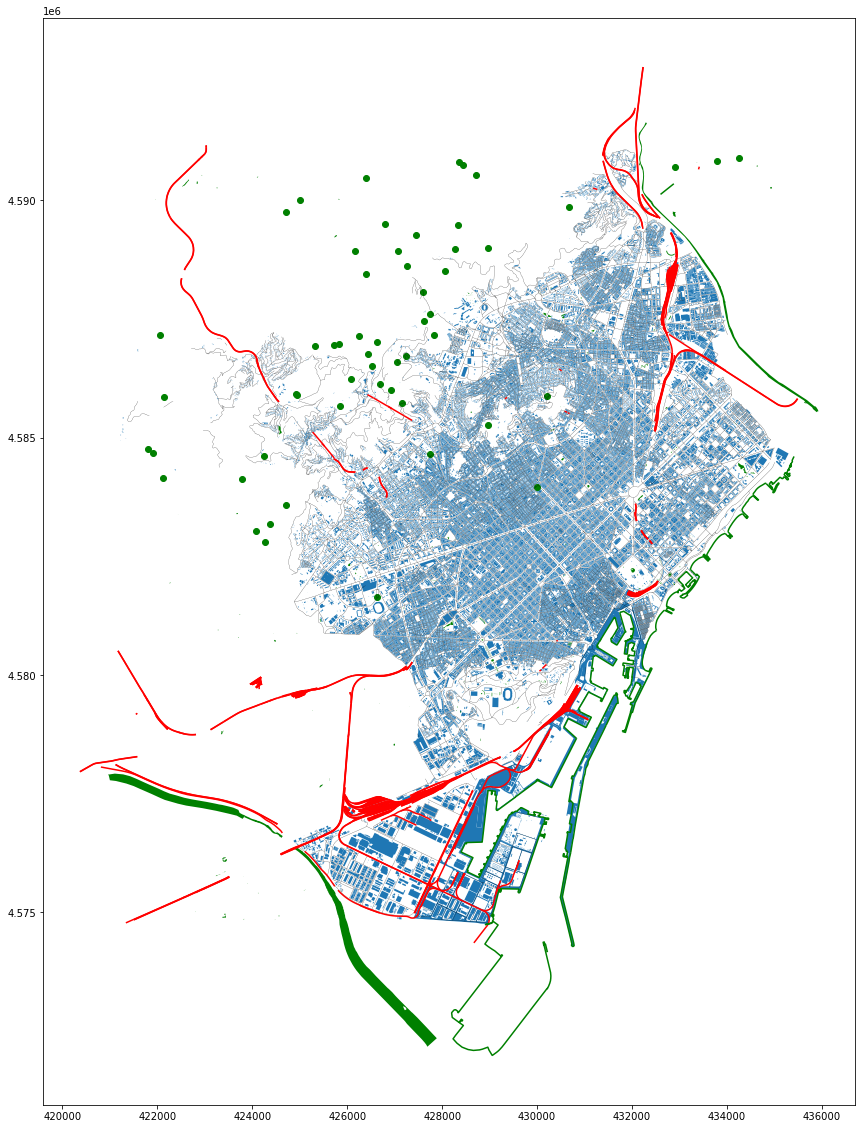

In [65]:
ax = buildings.plot(figsize=(20, 20))
roads.plot(ax=ax, linewidth=.2, color='k')
railway.plot(ax=ax, color='r')
water.plot(ax=ax, color='g')

In [67]:
data = "https://opendata-ajuntament.barcelona.cat/data/dataset/808daafa-d9ce-48c0-925a-fa5afdb1ed41/resource/cd800462-f326-429f-a67a-c69b7fc4c50a/download"
path = "../../urbangrammar_samba/sp_sig_concept/barcelona/admin/admin_units"
download(data, path, kind="zip")

Creating data folder...

file_sizes: 100%|██████████████████████████| 2.82M/2.82M [00:02<00:00, 1.15MB/s]
Extracting zip file...
Successfully downloaded / unzipped to ../../urbangrammar_samba/sp_sig_concept/barcelona/admin/admin_units


'../../urbangrammar_samba/sp_sig_concept/barcelona/admin/admin_units'

In [68]:
admin = gpd.read_file("../../urbangrammar_samba/sp_sig_concept/barcelona/admin/admin_units/0301100100_UNITATS_ADM_POLIGONS.json")

In [69]:
admin

,FID,ID_ANNEX,ANNEXDESCR,ID_TEMA,TEMA_DESCR,ID_CONJUNT,CONJ_DESCR,ID_SUBCONJ,SCONJ_DESC,ID_ELEMENT,...,CODI_UA,TIPUS_UA,NOM,WEB1,WEB2,WEB3,FHEX_COLOR,Shape_Leng,Shape_Area,geometry
0,0,01,Grup - I,0104,Unitats Administratives,010411,Terme Municipal,01041101,Terme Municipal,0104110101,...,080193,TERME,Barcelona,http://www.bcn.cat,http://www.bcn.cat/estadistica/catala/dades/in...,http://www.bcn.cat/estadistica/catala/document...,#000000,114036.624503,1.017050e+08,"MULTIPOLYGON (((432115.848 4590999.098, 432010..."
1,1,01,Grup - I,0104,Unitats Administratives,010412,Districtes,01041201,Districte,0104120101,...,01,DISTRICTE,Ciutat Vella,http://www.bcn.cat/ciutatvella,http://www.bcn.cat/estadistica/catala/dades/gu...,http://www.bcn.cat/estadistica/catala/document...,#000000,21366.961806,4.204931e+06,"POLYGON ((431733.736 4582441.816, 431645.093 4..."
2,2,01,Grup - I,0104,Unitats Administratives,010412,Districtes,01041201,Districte,0104120101,...,02,DISTRICTE,Eixample,http://www.bcn.cat/eixample,http://www.bcn.cat/estadistica/catala/dades/gu...,http://www.bcn.cat/estadistica/catala/document...,#000000,13931.644175,7.464303e+06,"POLYGON ((432033.184 4583665.032, 432033.186 4..."
3,3,01,Grup - I,0104,Unitats Administratives,010412,Districtes,01041201,Districte,0104120101,...,03,DISTRICTE,Sants-Montjuïc,http://www.bcn.cat/sants-montjuic,http://www.bcn.cat/estadistica/catala/dades/gu...,http://www.bcn.cat/estadistica/catala/document...,#000000,46711.856798,2.287985e+07,"MULTIPOLYGON (((428773.911 4580873.742, 428692..."
4,4,01,Grup - I,0104,Unitats Administratives,010412,Districtes,01041201,Districte,0104120101,...,04,DISTRICTE,Les Corts,http://www.bcn.cat/lescorts,http://www.bcn.cat/estadistica/catala/dades/gu...,http://www.bcn.cat/estadistica/catala/document...,#000000,12551.602001,6.010769e+06,"POLYGON ((425054.670 4583672.560, 425047.220 4..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1496,1496,01,Grup - I,0104,Unitats Administratives,010418,Zones urban audit_sub-city districts,01041801,Zones urban audit_sub-city districts,0104180101,...,,ZUA,,,,,#E66900,6779.746960,1.226953e+06,"POLYGON ((434226.753 4584675.137, 434133.314 4..."
1497,1497,01,Grup - I,0104,Unitats Administratives,010418,Zones urban audit_sub-city districts,01041801,Zones urban audit_sub-city districts,0104180101,...,,ZUA,,,,,#E66900,5126.839792,1.085740e+06,"POLYGON ((432758.475 4584096.289, 432758.495 4..."
1498,1498,01,Grup - I,0104,Unitats Administratives,010418,Zones urban audit_sub-city districts,01041801,Zones urban audit_sub-city districts,0104180101,...,,ZUA,,,,,#E66900,3473.157532,7.339890e+05,"POLYGON ((432900.094 4584704.562, 432930.448 4..."
1499,1499,01,Grup - I,0104,Unitats Administratives,010418,Zones urban audit_sub-city districts,01041801,Zones urban audit_sub-city districts,0104180101,...,,ZUA,,,,,#E66900,4569.298915,1.129978e+06,"POLYGON ((433770.023 4586475.362, 433726.353 4..."


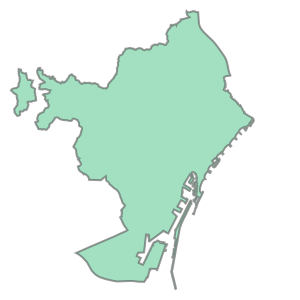

In [70]:
admin.loc[0, 'geometry']

## Data preprocessing

Building checks

In [93]:
buildings = gpd.read_file("../../urbangrammar_samba/sp_sig_concept/barcelona/buildings/A.ES.SDGC.BU.08900.building.gml")

/opt/conda/lib/python3.8/site-packages/geopandas/geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


In [94]:
buildings = buildings.explode()

In [95]:
check = momepy.CheckTessellationInput(buildings)

/opt/conda/lib/python3.8/site-packages/momepy/utils.py:1003: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  shrink = shrink[~(shrink.is_empty | shrink.geometry.isna())]


Collapsed features  : 86
Split features      : 339
Overlapping features: 0


In [98]:
check.collapse.area.max()

22.907883144854168

In [99]:
buildings = buildings.drop(check.collapse.index)

In [100]:
buildings.shape

(81440, 25)

In [101]:
buildings["uID"] = range(len(buildings))

In [102]:
buildings.to_parquet("../../urbangrammar_samba/sp_sig_concept/barcelona/buildings.pq")

<ipython-input-102-e980985fe82b>:1: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  buildings.to_parquet("../../urbangrammar_samba/sp_sig_concept/barcelona/buildings.pq")


Barrier checks

In [104]:
roads.geom_type.unique()

array(['LineString'], dtype=object)

In [109]:
railway.geom_type.unique()

array(['LineString'], dtype=object)

In [116]:
extended_railway = utils.momepy.extend_lines(railway, 30, target=roads, extension=.1)

## Generate geography

### Enclosures

In [2]:
buildings = gpd.read_parquet("../../urbangrammar_samba/sp_sig_concept/barcelona/buildings.pq")
roads = gpd.read_file("../../urbangrammar_samba/sp_sig_concept/barcelona/streets/BCN_GrafVial_Trams_ETRS89_SHP.shp")
railway = gpd.read_parquet("../../urbangrammar_samba/sp_sig_concept/barcelona/barrriers/railway.pq")
admin = gpd.read_file("../../urbangrammar_samba/sp_sig_concept/barcelona/admin/admin_units/0301100100_UNITATS_ADM_POLIGONS.json")

In [3]:
extended_railway = utils.momepy.extend_lines(railway, 30, target=roads, extension=.1)

In [4]:
%%time
enclosures = utils.momepy.enclosures(roads, limit=admin.iloc[[0]], additional_barriers=[extended_railway])

CPU times: user 1.4 s, sys: 8.11 ms, total: 1.41 s
Wall time: 1.41 s


In [5]:
enclosures

,eID,geometry
0,0,"POLYGON ((432108.315 4581042.075, 432149.471 4..."
1,1,"POLYGON ((432149.471 4581053.136, 432108.315 4..."
2,2,"POLYGON ((432149.471 4581053.136, 432163.827 4..."
3,3,"POLYGON ((432163.827 4581056.757, 432149.471 4..."
4,4,"POLYGON ((432163.827 4581056.757, 432178.516 4..."
...,...,...
5855,5855,"POLYGON ((427480.333 4577076.215, 427501.055 4..."
5856,5856,"POLYGON ((427520.606 4577066.376, 427517.205 4..."
5857,5857,"POLYGON ((426836.909 4583807.381, 426836.623 4..."
5858,5858,"POLYGON ((426814.906 4583712.215, 426823.515 4..."


<AxesSubplot:>

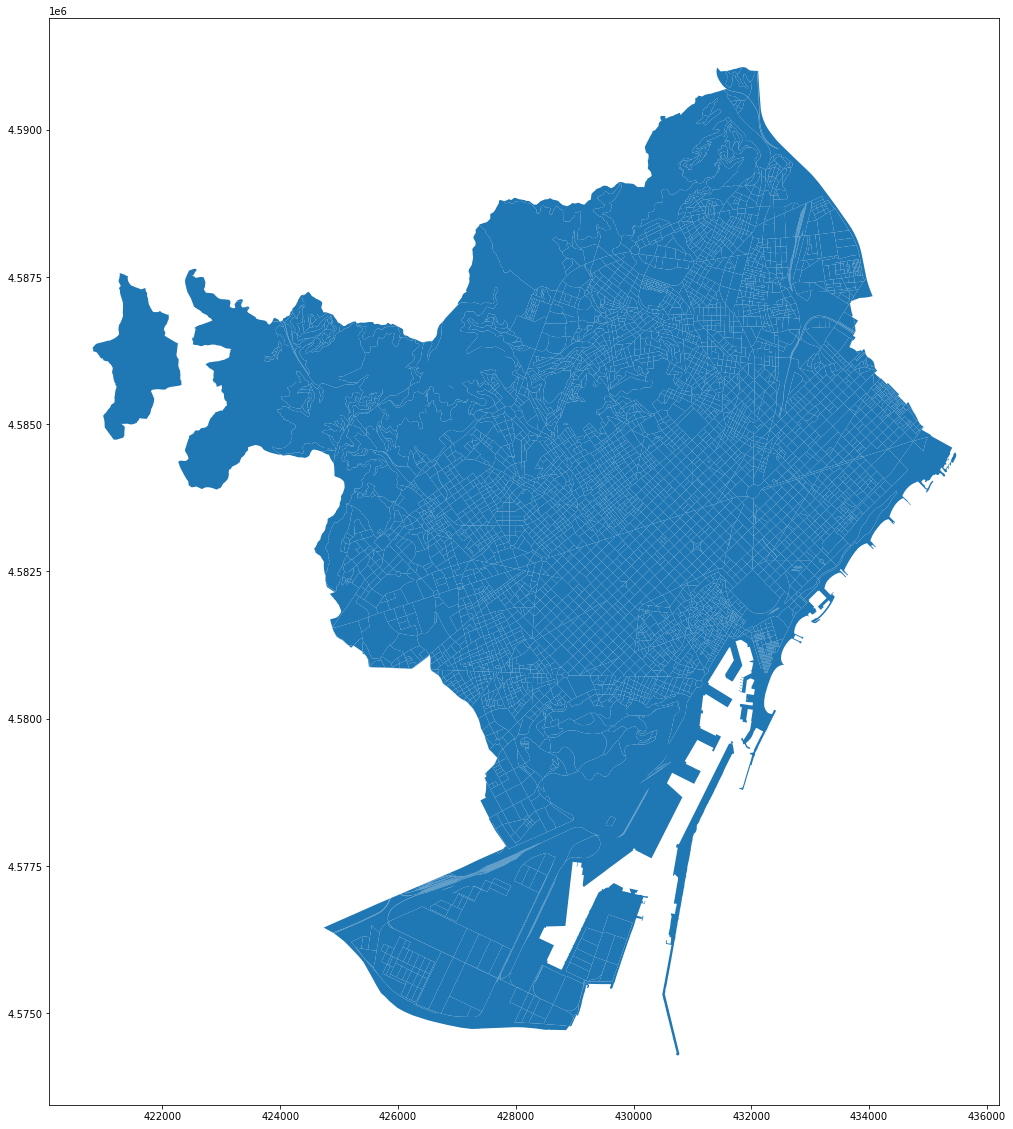

In [6]:
enclosures.plot(figsize=(20,20))

In [7]:
%%time
tess = utils.momepy.Tessellation(buildings, 'uID', enclosures=enclosures)

CPU times: user 48min 53s, sys: 4min 6s, total: 53min
Wall time: 19min 19s


<AxesSubplot:>

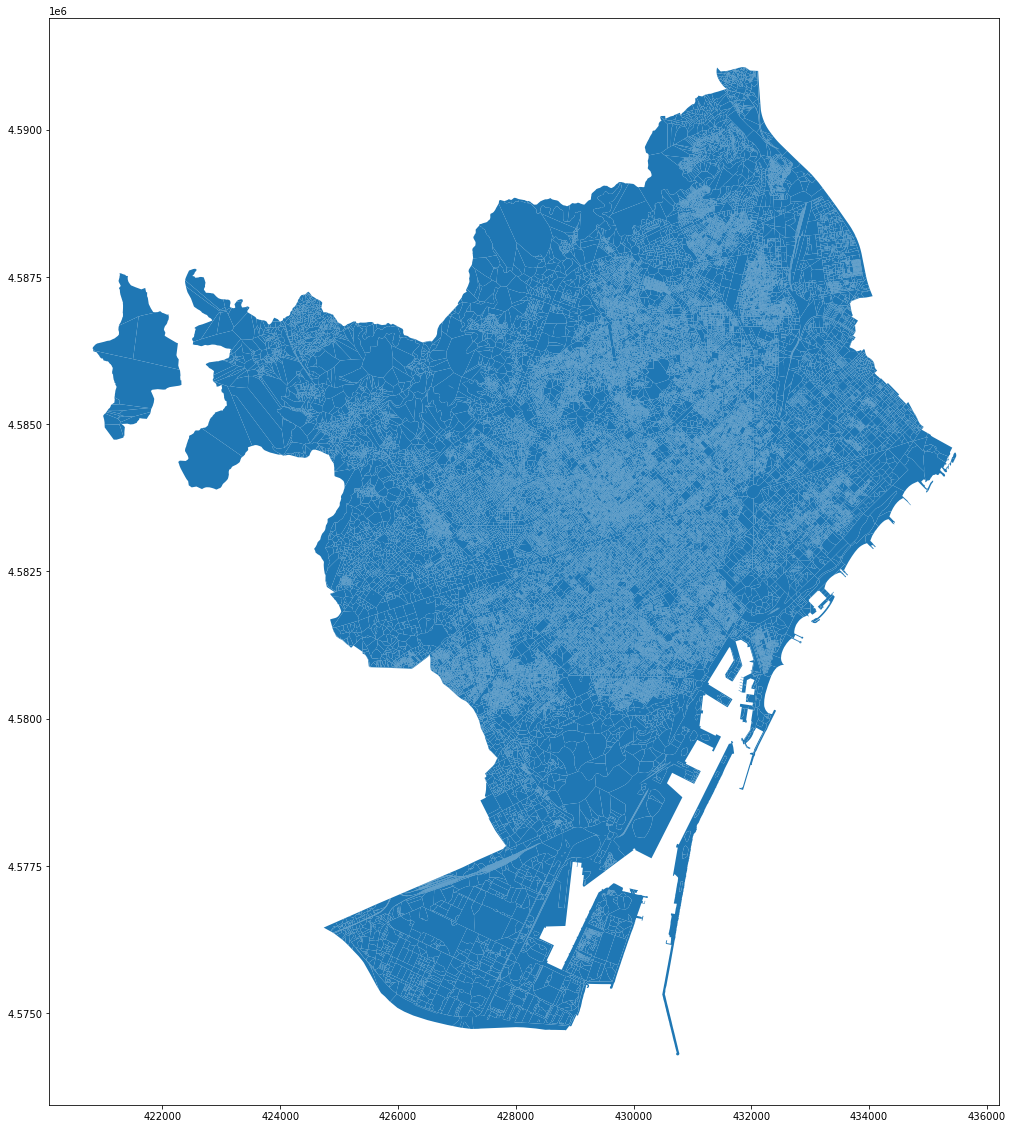

In [8]:
tess.tessellation.plot(figsize=(20, 20))

In [9]:
tess.tessellation.to_parquet("../../urbangrammar_samba/sp_sig_concept/barcelona/tessellation.pq")

<ipython-input-9-eb36e9e63444>:1: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  tess.tessellation.to_parquet("../../urbangrammar_samba/sp_sig_concept/barcelona/tessellation.pq")


In [10]:
enclosures.to_parquet("../../urbangrammar_samba/sp_sig_concept/barcelona/enclosures.pq")

<ipython-input-10-a76e72ca4c78>:1: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  enclosures.to_parquet("../../urbangrammar_samba/sp_sig_concept/barcelona/enclosures.pq")


## Primary morphometric characters

In [2]:
tess = gpd.read_parquet("../../urbangrammar_samba/sp_sig_concept/barcelona/tessellation.pq")
enclosures = gpd.read_parquet("../../urbangrammar_samba/sp_sig_concept/barcelona/enclosures.pq")
blg = gpd.read_parquet("../../urbangrammar_samba/sp_sig_concept/barcelona/buildings.pq")
streets = gpd.read_file("../../urbangrammar_samba/sp_sig_concept/barcelona/streets/BCN_GrafVial_Trams_ETRS89_SHP.shp")

In [3]:
tess = tess.rename_geometry("tessellation").merge(blg[['uID', 'geometry']].rename_geometry("buildings"), on='uID', how='left')

In [4]:
tess['tID'] = range(len(tess))

In [5]:
tess

,uID,tessellation,eID,buildings,tID
0,32004.0,"POLYGON ((432134.537 4581026.154, 432114.514 4...",0,"POLYGON ((432150.502 4581030.798, 432148.781 4...",0
1,32005.0,"POLYGON ((432143.300 4581011.416, 432142.423 4...",0,"POLYGON ((432141.079 4581028.136, 432143.721 4...",1
2,32006.0,"POLYGON ((432119.125 4581004.320, 432141.346 4...",0,"POLYGON ((432148.111 4581012.778, 432148.341 4...",2
3,32007.0,"POLYGON ((432148.249 4581003.971, 432148.271 4...",0,"POLYGON ((432159.642 4581004.302, 432160.339 4...",3
4,32008.0,"POLYGON ((432148.624 4580987.010, 432147.673 4...",0,"POLYGON ((432155.041 4580997.493, 432155.961 4...",4
...,...,...,...,...,...
82370,56448.0,"POLYGON ((427288.332 4577151.951, 427302.223 4...",5852,"POLYGON ((427233.783 4576977.073, 427229.417 4...",82370
82371,NaN,"POLYGON ((427407.654 4577101.819, 427405.996 4...",5853,None,82371
82372,NaN,"POLYGON ((427194.177 4576961.126, 427213.001 4...",5854,None,82372
82373,NaN,"POLYGON ((427480.333 4577076.215, 427501.055 4...",5855,None,82373


In [6]:
blg = tess.set_geometry('buildings').dropna()

In [7]:
%time blg['sdbAre'] = momepy.Area(blg).series
%time blg['sdbPer'] = momepy.Perimeter(blg).series
%time blg['sdbCoA'] = momepy.CourtyardArea(blg, 'sdbAre').series

%time blg['ssbCCo'] = momepy.CircularCompactness(blg, 'sdbAre').series
%time blg['ssbCor'] = momepy.Corners(blg).series
%time blg['ssbSqu'] = momepy.Squareness(blg).series
%time blg['ssbERI'] = momepy.EquivalentRectangularIndex(blg, 'sdbAre', 'sdbPer').series
%time blg['ssbElo'] = momepy.Elongation(blg).series

CPU times: user 16.2 ms, sys: 106 µs, total: 16.3 ms
Wall time: 15.1 ms
CPU times: user 17.4 ms, sys: 704 µs, total: 18.1 ms
Wall time: 17.6 ms
CPU times: user 113 ms, sys: 22.7 ms, total: 135 ms
Wall time: 132 ms


  0%|          | 0/81567 [00:00<?, ?it/s]/opt/conda/lib/python3.8/site-packages/momepy/shape.py:773: RuntimeWarning: invalid value encountered in arccos
  angle = np.arccos(cosine_angle)
  1%|          | 436/81567 [00:00<00:18, 4358.95it/s]

CPU times: user 4.73 s, sys: 33.5 ms, total: 4.76 s
Wall time: 4.74 s


  0%|          | 0/81567 [00:00<?, ?it/s]/opt/conda/lib/python3.8/site-packages/momepy/shape.py:862: RuntimeWarning: invalid value encountered in arccos
  angle = np.degrees(np.arccos(cosine_angle))
  0%|          | 248/81567 [00:00<00:32, 2478.35it/s]

CPU times: user 25.4 s, sys: 189 ms, total: 25.5 s
Wall time: 25.4 s


 95%|█████████▌| 77673/81567 [00:43<00:02, 1701.29it/s]/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 81567/81567 [00:47<00:00, 1710.51it/s]


CPU times: user 47.6 s, sys: 593 ms, total: 48.2 s
Wall time: 47.7 s
CPU times: user 32.9 s, sys: 39.1 ms, total: 33 s
Wall time: 33 s
CPU times: user 32.9 s, sys: 7.67 ms, total: 32.9 s
Wall time: 32.9 s


In [8]:
%time cencon = momepy.CentroidCorners(blg)
blg['ssbCCM'] = cencon.mean
blg['ssbCCD'] = cencon.std

%time blg['stbOri'] = momepy.Orientation(blg).series
 
%time tess['stcOri'] = momepy.Orientation(tess).series

  0%|          | 0/81567 [00:00<?, ?it/s]/opt/conda/lib/python3.8/site-packages/momepy/shape.py:1080: RuntimeWarning: invalid value encountered in arccos
  angle = np.arccos(cosine_angle)
  0%|          | 283/81567 [00:00<00:28, 2821.77it/s]

CPU times: user 46.1 s, sys: 116 ms, total: 46.3 s
Wall time: 46.1 s


  0%|          | 195/82375 [00:00<00:42, 1943.83it/s]

CPU times: user 35.7 s, sys: 72.3 ms, total: 35.8 s
Wall time: 35.7 s


100%|██████████| 82375/82375 [01:42<00:00, 800.64it/s] 

CPU times: user 1min 43s, sys: 132 ms, total: 1min 43s
Wall time: 1min 42s


In [9]:
tess = tess.merge(blg[['tID', 'stbOri']], on='tID', how='left')

In [10]:
%time tess['stbCeA'] = (tess['stbOri'] - tess['stcOri']).abs()

CPU times: user 2.84 ms, sys: 0 ns, total: 2.84 ms
Wall time: 1.37 ms


In [11]:
%time tess['sdcLAL'] = momepy.LongestAxisLength(tess).series
%time tess['sdcAre'] = momepy.Area(tess).series
%time tess['sscCCo'] = momepy.CircularCompactness(tess, 'sdcAre').series
%time tess['sscERI'] = momepy.EquivalentRectangularIndex(tess, 'sdcAre').series

%time tess['sicCAR'] = tess.buildings.area / tess['sdcAre']

CPU times: user 13.8 s, sys: 11.9 ms, total: 13.8 s
Wall time: 13.8 s
CPU times: user 95.1 ms, sys: 0 ns, total: 95.1 ms
Wall time: 94.7 ms
CPU times: user 14.1 s, sys: 19.9 ms, total: 14.1 s
Wall time: 14.1 s
CPU times: user 1min 39s, sys: 143 ms, total: 1min 39s
Wall time: 1min 39s
CPU times: user 16.6 ms, sys: 5 µs, total: 16.6 ms
Wall time: 15.4 ms


In [12]:
%time blg["mtbSWR"] = momepy.SharedWallsRatio(blg).series

CPU times: user 32.8 s, sys: 0 ns, total: 32.8 s
Wall time: 32.8 s


In [13]:
%time queen_1 = libpysal.weights.contiguity.Queen.from_dataframe(tess, ids="tID", geom_col='tessellation')

CPU times: user 1min 2s, sys: 1.26 s, total: 1min 4s
Wall time: 1min 4s


/opt/conda/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  warnings.warn(message)


In [14]:
%time tess["mtbAli"] = momepy.Alignment(tess.set_geometry("buildings"), queen_1, "tID", "stbOri").series

100%|██████████| 82375/82375 [00:34<00:00, 2390.71it/s]

CPU times: user 34.9 s, sys: 1.71 s, total: 36.6 s
Wall time: 34.5 s


In [15]:
%time tess["mtbNDi"] = utils.momepy.NeighborDistance(tess.set_geometry("buildings"), queen_1, "tID").series

100%|██████████| 82375/82375 [00:40<00:00, 2040.14it/s]

CPU times: user 40.4 s, sys: 120 ms, total: 40.5 s
Wall time: 40.4 s


In [16]:
%time tess["mtcWNe"] = momepy.Neighbors(tess, queen_1, "tID", weighted=True).series
%time tess["mdcAre"] = momepy.CoveredArea(tess, queen_1, "tID").series

  0%|          | 0/82375 [00:00<?, ?it/s]

CPU times: user 853 ms, sys: 37 µs, total: 853 ms
Wall time: 849 ms


100%|██████████| 82375/82375 [00:13<00:00, 5988.93it/s]

CPU times: user 14.1 s, sys: 1.3 s, total: 15.4 s
Wall time: 13.9 s


In [17]:
%time blg_q1 = libpysal.weights.contiguity.Queen.from_dataframe(blg, geom_col='buildings', silence_warnings=True)
 
%time blg["ldbPWL"] = momepy.PerimeterWall(blg, blg_q1).series

  0%|          | 0/81567 [00:00<?, ?it/s]

CPU times: user 8.53 s, sys: 132 ms, total: 8.66 s
Wall time: 8.65 s


100%|██████████| 81567/81567 [00:00<00:00, 3032493.28it/s]

CPU times: user 49.6 s, sys: 5.13 s, total: 54.8 s
Wall time: 46.1 s


In [18]:
%time blg["libNCo"] = utils.momepy.Courtyards(blg, spatial_weights=blg_q1).series

100%|██████████| 81567/81567 [00:51<00:00, 1586.14it/s]

CPU times: user 55.2 s, sys: 4.97 s, total: 1min
Wall time: 51.5 s


In [19]:
%time queen_3 = momepy.sw_high(k=3, weights=queen_1)

CPU times: user 5.57 s, sys: 180 ms, total: 5.75 s
Wall time: 5.74 s


In [20]:
%time tess['ltbIBD'] = utils.momepy.MeanInterbuildingDistance(tess.set_geometry('buildings'), queen_1, 'tID', queen_3).series

  1%|          | 416/82375 [00:00<00:37, 2157.26it/s]

Computing mean interbuilding distances...


100%|█████████▉| 82124/82375 [00:55<00:00, 570.74it/s] /home/jovyan/work/spatial_signatures_concept/code/utils/momepy.py:1099: RuntimeWarning: Mean of empty slice
  np.nanmean([x[-1] for x in list(sub.edges.data("weight"))])
100%|██████████| 82375/82375 [00:55<00:00, 1475.96it/s]


CPU times: user 1min 5s, sys: 563 ms, total: 1min 6s
Wall time: 1min 5s


In [21]:
# get nid and primary nid here
%time links = momepy.get_network_ratio(tess, streets)

CPU times: user 1min 17s, sys: 8.43 ms, total: 1min 17s
Wall time: 1min 17s


In [22]:
tess[['edgeID_keys', 'edgeID_values']] = links

In [23]:
keys = tess.edgeID_values.apply(lambda a: np.argmax(a))
tess['edgeID_primary'] = [inds[i] for inds, i in zip(tess.edgeID_keys, keys)]

In [24]:
blg = blg.merge(tess[['tID', 'edgeID_primary']], on='tID', how='left')

In [25]:
streets['edgeID_primary'] = range(len(streets))

In [26]:
%time streets["sdsLen"] = momepy.Perimeter(streets).series
%time tess["stcSAl"] = momepy.StreetAlignment(tess, streets, "stcOri", "edgeID_primary").series
%time blg["stbSAl"] = momepy.StreetAlignment(blg, streets, "stbOri", "edgeID_primary").series

CPU times: user 1.86 ms, sys: 39 µs, total: 1.9 ms
Wall time: 999 µs
CPU times: user 402 ms, sys: 14 µs, total: 402 ms
Wall time: 401 ms
CPU times: user 411 ms, sys: 0 ns, total: 411 ms
Wall time: 410 ms


In [27]:
%time profile = momepy.StreetProfile(streets, blg, distance=3)
streets["sdsSPW"] = profile.w
streets["sdsSPO"] = profile.o
streets["sdsSWD"] = profile.wd

/opt/conda/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


CPU times: user 2min 53s, sys: 55.7 ms, total: 2min 53s
Wall time: 2min 53s


In [28]:
%time streets["sssLin"] = momepy.Linearity(streets).series

CPU times: user 258 ms, sys: 3.9 ms, total: 262 ms
Wall time: 261 ms


In [29]:
%%time 
# Area Covered by each edge
vals = {x:[] for x in range(len(streets))}
for i, keys in enumerate(tess.edgeID_keys):
    for k in keys:
        vals[k].append(i)
area_sums = []
for inds in vals.values():
    area_sums.append(tess.sdcAre.iloc[inds].sum())
streets['sdsAre'] = area_sums

CPU times: user 1.38 s, sys: 3.99 ms, total: 1.38 s
Wall time: 1.38 s


In [30]:
%%time
# Buildings per meter
bpm = []
for inds, l in zip(vals.values(), streets.sdsLen):
    bpm.append(tess.buildings.iloc[inds].notna().sum() / l if len(inds) > 0 else 0)
streets['sisBpM'] = bpm

CPU times: user 4.34 s, sys: 15.8 ms, total: 4.35 s
Wall time: 4.34 s


In [31]:
str_q1 = libpysal.weights.contiguity.Queen.from_dataframe(streets, silence_warnings=True)
 
streets["misRea"] = momepy.Reached(
    streets, tess, "edgeID_primary", "edgeID_primary", spatial_weights=str_q1, mode="count"
).series
streets["mdsAre"] = momepy.Reached(streets, tess, "edgeID_primary", "edgeID_primary", spatial_weights=str_q1,
                               mode="sum").series

100%|██████████| 14831/14831 [00:25<00:00, 588.91it/s]


In [32]:
%time graph = momepy.gdf_to_nx(streets)
 
print("node degree")
graph = momepy.node_degree(graph)
 
print("subgraph")
graph = momepy.subgraph(
    graph,
    radius=5,
    meshedness=True,
    cds_length=False,
    mode="sum",
    degree="degree",
    length="mm_len",
    mean_node_degree=False,
    proportion={0: True, 3: True, 4: True},
    cyclomatic=False,
    edge_node_ratio=False,
    gamma=False,
    local_closeness=True,
    closeness_weight="mm_len",
)
print("cds length")
graph = momepy.cds_length(graph, radius=3, name="ldsCDL")
 
print("clustering")
graph = momepy.clustering(graph, name="xcnSCl")
 
print("mean_node_dist")
graph = momepy.mean_node_dist(graph, name="mtdMDi")
 
%time nodes, edges, sw = momepy.nx_to_gdf(graph, spatial_weights=True)

CPU times: user 2.68 s, sys: 0 ns, total: 2.68 s
Wall time: 2.68 s
node degree


  0%|          | 0/9484 [00:00<?, ?it/s]

subgraph


100%|██████████| 9484/9484 [00:19<00:00, 496.93it/s]


cds length


100%|██████████| 9484/9484 [00:06<00:00, 1490.19it/s]


clustering


  0%|          | 0/9484 [00:00<?, ?it/s]

mean_node_dist


100%|██████████| 9484/9484 [00:00<00:00, 70278.67it/s]


CPU times: user 402 ms, sys: 3 µs, total: 402 ms
Wall time: 401 ms


/opt/conda/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 41 disconnected components.
  warnings.warn(message)


In [33]:
%time edges_w3 = momepy.sw_high(k=3, gdf=edges)
%time edges["ldsMSL"] = momepy.SegmentsLength(edges, spatial_weights=edges_w3, mean=True).series
 
%time nodes_w5 = momepy.sw_high(k=5, weights=sw)
%time nodes["lddNDe"] = momepy.NodeDensity(nodes, edges, nodes_w5).series
nodes["linWID"] = momepy.NodeDensity(
    nodes, edges, nodes_w5, weighted=True, node_degree="degree"
).series

 18%|█▊        | 2617/14831 [00:00<00:00, 13149.51it/s]

CPU times: user 1.46 s, sys: 7.82 ms, total: 1.46 s
Wall time: 1.46 s


100%|██████████| 14831/14831 [00:01<00:00, 13172.95it/s]


CPU times: user 1.12 s, sys: 181 ms, total: 1.3 s
Wall time: 1.13 s


  2%|▏         | 153/9484 [00:00<00:06, 1528.01it/s]

CPU times: user 817 ms, sys: 0 ns, total: 817 ms
Wall time: 816 ms


  1%|          | 79/9484 [00:00<00:12, 783.01it/s]

CPU times: user 6.25 s, sys: 11.7 ms, total: 6.26 s
Wall time: 6.24 s


100%|██████████| 9484/9484 [00:12<00:00, 784.32it/s]


In [34]:
enclosures["ldeAre"] = momepy.Area(enclosures).series
enclosures["ldePer"] = momepy.Perimeter(enclosures).series
enclosures["lseCCo"] = momepy.CircularCompactness(enclosures, "ldeAre").series
enclosures["lseERI"] = momepy.EquivalentRectangularIndex(enclosures, "ldeAre", "ldePer").series
enclosures["lseCWA"] = momepy.CompactnessWeightedAxis(enclosures, "ldeAre", "ldePer").series
enclosures["lteOri"] = momepy.Orientation(enclosures).series
 
blo_q1 = libpysal.weights.contiguity.Queen.from_dataframe(enclosures, ids="eID")
 
inp, res = enclosures.sindex.query_bulk(enclosures.geometry, predicate='intersects')
indices, counts = np.unique(inp, return_counts=True)
enclosures['neighbors'] = counts - 1
enclosures['lteWNB'] = enclosures['neighbors'] / enclosures['ldePer']

100%|██████████| 5860/5860 [00:02<00:00, 2870.77it/s]
/opt/conda/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 5466, 5467.
  warnings.warn(message)


In [35]:
# Measure weighted cells within enclosure
encl_counts = tess.groupby('eID').count()
merged = enclosures[['eID', 'ldeAre']].merge(encl_counts[['tessellation']], how='left', on='eID')
enclosures['lieWCe'] = merged['tessellation'] / merged['ldeAre']

In [36]:
tess['ltcWRE'] = momepy.BlocksCount(tess, 'eID', queen_3, 'tID').series

100%|██████████| 82375/82375 [00:53<00:00, 1551.67it/s]


In [37]:
# get node id
%time links = momepy.get_network_ratio(tess, edges)
tess[['edgeID_keys2', 'edgeID_values2']] = links
%time tess['nodeID'] = momepy.get_node_id(tess, nodes, edges, node_id='nodeID', edge_keys='edgeID_keys2', edge_values='edgeID_values2')

  0%|          | 293/82375 [00:00<00:28, 2920.18it/s]

CPU times: user 1min 18s, sys: 232 µs, total: 1min 18s
Wall time: 1min 18s


100%|██████████| 82375/82375 [00:28<00:00, 2849.70it/s]

CPU times: user 28.9 s, sys: 87.1 ms, total: 29 s
Wall time: 28.9 s


In [38]:
%%time
nodes["sddAre"] = momepy.Reached(
    nodes, tess, "nodeID", "nodeID", mode="sum", values="sdcAre"
).series

100%|██████████| 9484/9484 [00:08<00:00, 1181.84it/s]

CPU times: user 8.06 s, sys: 7.76 ms, total: 8.07 s
Wall time: 8.03 s


In [39]:
# link all to ET

In [40]:
tess.columns

Index(['uID', 'tessellation', 'eID', 'buildings', 'tID', 'stcOri', 'stbOri',
       'stbCeA', 'sdcLAL', 'sdcAre', 'sscCCo', 'sscERI', 'sicCAR', 'mtbAli',
       'mtbNDi', 'mtcWNe', 'mdcAre', 'ltbIBD', 'edgeID_keys', 'edgeID_values',
       'edgeID_primary', 'stcSAl', 'ltcWRE', 'edgeID_keys2', 'edgeID_values2',
       'nodeID'],
      dtype='object')

In [41]:
blg.columns

Index(['uID', 'tessellation', 'eID', 'buildings', 'tID', 'sdbAre', 'sdbPer',
       'sdbCoA', 'ssbCCo', 'ssbCor', 'ssbSqu', 'ssbERI', 'ssbElo', 'ssbCCM',
       'ssbCCD', 'stbOri', 'mtbSWR', 'ldbPWL', 'libNCo', 'edgeID_primary',
       'stbSAl'],
      dtype='object')

In [42]:
edges.columns

Index(['COORD_X', 'COORD_Y', 'LONGITUD', 'ANGLE', 'C_Tram', 'C_Nus_I',
       'C_Nus_F', 'Distric_D', 'NDistric_D', 'Illa_D', 'CVia_D', 'TVia_D',
       'NVia_D', 'Tram_Dret', 'Distric_E', 'NDistric_E', 'Illa_E', 'CVia_E',
       'TVia_E', 'NVia_E', 'Tram_Esq', 'geometry', 'edgeID_primary', 'sdsLen',
       'sdsSPW', 'sdsSPO', 'sdsSWD', 'sssLin', 'sdsAre', 'sisBpM', 'misRea',
       'mdsAre', 'mm_len', 'cdsbool', 'node_start', 'node_end', 'ldsMSL'],
      dtype='object')

In [43]:
nodes.columns

Index(['degree', 'meshedness', 'proportion_3', 'proportion_4', 'proportion_0',
       'local_closeness', 'ldsCDL', 'xcnSCl', 'mtdMDi', 'nodeID', 'geometry',
       'lddNDe', 'linWID', 'sddAre'],
      dtype='object')

In [44]:
enclosures.columns

Index(['eID', 'geometry', 'ldeAre', 'ldePer', 'lseCCo', 'lseERI', 'lseCWA',
       'lteOri', 'neighbors', 'lteWNB', 'lieWCe'],
      dtype='object')

In [45]:
data = tess.merge(
    blg[['tID', 'sdbAre', 'sdbPer', 'sdbCoA', 'ssbCCo', 'ssbCor', 'ssbSqu', 'ssbERI', 'ssbElo', 'ssbCCM', 'ssbCCD', 'mtbSWR', 'ldbPWL', 'stbSAl', 'libNCo']],
    on='tID',
    how='left'
)
data = data.merge(
    edges[["sdsLen", 'sdsSPW', 'sdsSPO', 'sdsSWD', 'sssLin', 'sdsAre', 'sisBpM', 'misRea', 'mdsAre', 'ldsMSL', 'edgeID_primary']],
    on='edgeID_primary',
    how='left'
)
data = data.merge(
    nodes[['degree', 'meshedness', 'proportion_3', 'proportion_4', 'proportion_0', 'local_closeness', 'ldsCDL', 'xcnSCl', 'mtdMDi', 'nodeID', 'lddNDe', 'linWID', 'sddAre']],
    on='nodeID',
    how='left'
)
data = data.merge(
    enclosures[['eID', 'ldeAre', 'ldePer', 'lseCCo', 'lseERI', 'lseCWA', 'lteOri', 'lteWNB', 'lieWCe']],
    on='eID',
    how='left'
)

In [46]:
data.columns

Index(['uID', 'tessellation', 'eID', 'buildings', 'tID', 'stcOri', 'stbOri',
       'stbCeA', 'sdcLAL', 'sdcAre', 'sscCCo', 'sscERI', 'sicCAR', 'mtbAli',
       'mtbNDi', 'mtcWNe', 'mdcAre', 'ltbIBD', 'edgeID_keys', 'edgeID_values',
       'edgeID_primary', 'stcSAl', 'ltcWRE', 'edgeID_keys2', 'edgeID_values2',
       'nodeID', 'sdbAre', 'sdbPer', 'sdbCoA', 'ssbCCo', 'ssbCor', 'ssbSqu',
       'ssbERI', 'ssbElo', 'ssbCCM', 'ssbCCD', 'mtbSWR', 'ldbPWL', 'stbSAl',
       'libNCo', 'sdsLen', 'sdsSPW', 'sdsSPO', 'sdsSWD', 'sssLin', 'sdsAre',
       'sisBpM', 'misRea', 'mdsAre', 'ldsMSL', 'degree', 'meshedness',
       'proportion_3', 'proportion_4', 'proportion_0', 'local_closeness',
       'ldsCDL', 'xcnSCl', 'mtdMDi', 'lddNDe', 'linWID', 'sddAre', 'ldeAre',
       'ldePer', 'lseCCo', 'lseERI', 'lseCWA', 'lteOri', 'lteWNB', 'lieWCe'],
      dtype='object')

In [47]:
data.to_parquet("../../urbangrammar_samba/sp_sig_concept/barcelona/data.pq")

<ipython-input-47-d28989122e2f>:1: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  data.to_parquet("../../urbangrammar_samba/sp_sig_concept/barcelona/data.pq")


In [48]:
tess.to_parquet("../../urbangrammar_samba/sp_sig_concept/barcelona/tess.pq")
blg.to_parquet("../../urbangrammar_samba/sp_sig_concept/barcelona/blg.pq")
nodes.to_parquet("../../urbangrammar_samba/sp_sig_concept/barcelona/nodes.pq")
edges.to_parquet("../../urbangrammar_samba/sp_sig_concept/barcelona/edges.pq")
enclosures.to_parquet("../../urbangrammar_samba/sp_sig_concept/barcelona/enclosures.pq")

<ipython-input-48-4cf848639ee8>:1: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  tess.to_parquet("../../urbangrammar_samba/sp_sig_concept/barcelona/tess.pq")
<ipython-input-48-4cf848639ee8>:2: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend u

## Convolutions

In [54]:
data.columns

Index(['uID', 'tessellation', 'eID', 'buildings', 'tID', 'stcOri', 'stbOri',
       'stbCeA', 'sdcLAL', 'sdcAre', 'sscCCo', 'sscERI', 'sicCAR', 'mtbAli',
       'mtbNDi', 'mtcWNe', 'mdcAre', 'ltbIBD', 'edgeID_keys', 'edgeID_values',
       'edgeID_primary', 'stcSAl', 'ltcWRE', 'edgeID_keys2', 'edgeID_values2',
       'nodeID', 'sdbAre', 'sdbPer', 'sdbCoA', 'ssbCCo', 'ssbCor', 'ssbSqu',
       'ssbERI', 'ssbElo', 'ssbCCM', 'ssbCCD', 'mtbSWR', 'ldbPWL', 'stbSAl',
       'libNCo', 'sdsLen', 'sdsSPW', 'sdsSPO', 'sdsSWD', 'sssLin', 'sdsAre',
       'sisBpM', 'misRea', 'mdsAre', 'ldsMSL', 'degree', 'meshedness',
       'proportion_3', 'proportion_4', 'proportion_0', 'local_closeness',
       'ldsCDL', 'xcnSCl', 'mtdMDi', 'lddNDe', 'linWID', 'sddAre', 'ldeAre',
       'ldePer', 'lseCCo', 'lseERI', 'lseCWA', 'lteOri', 'lteWNB', 'lieWCe'],
      dtype='object')

In [55]:
characters = ['stcOri', 'stbOri',
       'stbCeA', 'sdcLAL', 'sdcAre', 'sscCCo', 'sscERI', 'sicCAR', 'mtbAli',
       'mtbNDi', 'mtcWNe', 'mdcAre', 'ltbIBD',
       'stcSAl', 'ltcWRE',
       'sdbAre', 'sdbPer', 'sdbCoA', 'ssbCCo', 'ssbCor', 'ssbSqu',
       'ssbERI', 'ssbElo', 'ssbCCM', 'ssbCCD', 'mtbSWR', 'ldbPWL', 'stbSAl',
       'libNCo', 'sdsLen', 'sdsSPW', 'sdsSPO', 'sdsSWD', 'sssLin', 'sdsAre',
       'sisBpM', 'misRea', 'mdsAre', 'ldsMSL', 'degree', 'meshedness',
       'proportion_3', 'proportion_4', 'proportion_0', 'local_closeness',
       'ldsCDL', 'xcnSCl', 'mtdMDi', 'lddNDe', 'linWID', 'sddAre', 'ldeAre',
       'ldePer', 'lseCCo', 'lseERI', 'lseCWA', 'lteOri', 'lteWNB', 'lieWCe']

In [56]:
data = data.set_index('tID')[characters]

In [57]:
data

,stcOri,stbOri,stbCeA,sdcLAL,sdcAre,sscCCo,sscERI,sicCAR,mtbAli,mtbNDi,...,linWID,sddAre,ldeAre,ldePer,lseCCo,lseERI,lseCWA,lteOri,lteWNB,lieWCe
tID,,,,,,,,,,,,,,,,,,,,,
0,15.895018,15.799296,0.095722,48.296441,943.168405,0.514836,0.991567,0.173227,3.218920,10.090642,...,0.059999,2118.532010,4732.699661,306.482011,0.426154,0.999427,55.541969,15.977199,0.019577,0.001690
1,15.959191,15.987675,0.028484,45.972443,714.761540,0.430602,0.982033,0.334256,0.160965,0.000000,...,0.056307,3833.421785,4732.699661,306.482011,0.426154,0.999427,55.541969,15.977199,0.019577,0.001690
2,16.159193,16.121226,0.037966,43.656880,364.162654,0.243276,0.991853,0.337916,0.241171,0.000000,...,0.059999,2118.532010,4732.699661,306.482011,0.426154,0.999427,55.541969,15.977199,0.019577,0.001690
3,15.822243,15.772435,0.049808,43.632135,339.135425,0.226814,0.983700,0.343878,0.262707,0.000000,...,0.056307,3833.421785,4732.699661,306.482011,0.426154,0.999427,55.541969,15.977199,0.019577,0.001690
4,15.764376,15.595811,0.168565,43.835958,269.075657,0.178289,0.894589,0.452924,0.604087,0.000000,...,0.049137,1593.936143,4732.699661,306.482011,0.426154,0.999427,55.541969,15.977199,0.019577,0.001690
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82370,26.262159,25.469061,0.793098,255.669487,26790.544600,0.521836,0.981490,0.522396,0.232599,21.199940,...,0.010598,80307.253955,26790.544600,691.439531,0.521836,0.981490,96.298206,26.262159,0.005785,0.000037
82371,24.875500,NaN,NaN,130.127525,969.276342,0.072882,0.800889,NaN,NaN,NaN,...,0.008765,95125.787387,969.276342,278.452869,0.072882,0.800889,139.655956,24.875500,0.014365,0.001032
82372,25.573647,NaN,NaN,120.740314,1850.795707,0.161646,0.972958,NaN,NaN,NaN,...,0.009042,20724.432870,1850.795707,271.054890,0.161646,0.972958,105.066393,25.573647,0.011068,0.000540


In [58]:
from tqdm import tqdm
import pandas as pd

convolutions = {}
for c in characters:
    convolutions[c] = []

# measure convolutions
for i in tqdm(data.index, total=data.shape[0]):
    neighbours = [i]
    neighbours += queen_1.neighbors[i]

    vicinity = data.loc[neighbours]
    for c in characters:
        convolutions[c].append(np.nanpercentile(vicinity[c], [25, 50, 75], interpolation='midpoint'))

 16%|█▌        | 13336/82375 [01:41<08:47, 130.95it/s]/opt/conda/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
100%|██████████| 82375/82375 [10:26<00:00, 131.59it/s]


NameError: name 'pd' is not defined

In [60]:
import pandas as pd

In [64]:
%time conv = pd.DataFrame(convolutions, index=data.index)
%time exploded = pd.concat([pd.DataFrame(conv[c].to_list(), columns=[c + '_q1', c + '_q2',c + '_q3']) for c in characters], axis=1)

CPU times: user 989 ms, sys: 7.28 ms, total: 996 ms
Wall time: 994 ms
CPU times: user 6.72 s, sys: 43.9 ms, total: 6.76 s
Wall time: 6.76 s


In [66]:
exploded.index = data.index
exploded

,stcOri_q1,stcOri_q2,stcOri_q3,stbOri_q1,stbOri_q2,stbOri_q3,stbCeA_q1,stbCeA_q2,stbCeA_q3,sdcLAL_q1,...,lseCWA_q3,lteOri_q1,lteOri_q2,lteOri_q3,lteWNB_q1,lteWNB_q2,lteWNB_q3,lieWCe_q1,lieWCe_q2,lieWCe_q3
tID,,,,,,,,,,,,,,,,,,,,,
0,15.628853,15.927105,15.987896,15.722108,15.893485,16.126171,0.062103,0.171894,0.265149,36.220705,...,83.845622,15.996900,16.016601,16.142931,0.019577,0.021098,0.027384,0.001625,0.001690,0.003033
1,15.927105,15.959191,16.059192,15.893485,15.987675,16.054451,0.033225,0.037966,0.066844,44.814662,...,55.541969,15.977199,15.977199,15.977199,0.019577,0.019577,0.019577,0.001690,0.001690,0.001690
2,15.890717,15.959191,16.059192,15.880055,15.987675,16.054451,0.033225,0.037966,0.043887,43.644507,...,55.541969,15.977199,15.977199,15.977199,0.019577,0.019577,0.019577,0.001690,0.001690,0.001690
3,15.793310,15.822243,15.990718,15.684123,15.772435,15.946831,0.043887,0.049808,0.109187,43.644507,...,55.541969,15.977199,15.977199,15.977199,0.019577,0.019577,0.019577,0.001690,0.001690,0.001690
4,15.793310,15.822243,15.899721,15.684123,15.772435,16.199898,0.109187,0.168565,0.409364,43.734046,...,55.541969,15.977199,15.977199,15.977199,0.019577,0.019577,0.019577,0.001690,0.001690,0.001690
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82370,24.875500,24.886939,25.573647,25.352761,25.352761,25.352761,11.287861,11.287861,11.287861,120.740314,...,139.655956,24.886939,25.573647,26.262159,0.005785,0.011068,0.014365,0.000052,0.000540,0.001032
82371,18.857356,24.881220,25.574549,24.845419,25.352761,25.608563,1.059855,6.470887,16.698894,168.287507,...,2360.077133,25.574549,26.694622,29.654019,0.004280,0.008197,0.012487,0.000052,0.000077,0.000567
82372,23.242862,25.420729,25.917903,25.469061,25.469336,25.533876,0.793098,3.010670,4.428292,238.630989,...,4580.498311,25.917903,29.221556,32.180953,0.002775,0.004280,0.006191,0.000052,0.000052,0.000053


In [67]:
exploded.to_parquet("../../urbangrammar_samba/sp_sig_concept/barcelona/convolutions.pq")